---
title: "SWD Properties"
---

## Setup

In [150]:
#| hide
import polars as pl
from ids_finder.utils.basic import load_catalog

from beforerr.r import py2rpy_polars
import rpy2.robjects as robjects

from ids_finder.pipelines.project.pipeline import process_events_l2

In [151]:
#| hide
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [152]:
catalog = load_catalog()

Connect `python` with `R` kernel

In [153]:
r = robjects.r
r.source('utils.R')

conv_pl = py2rpy_polars()


 Found  1  deps for  0/1  pkgs [⠋] Resolving standard (CRAN/BioC) packages
 
ℹ No downloads are needed

Installing...
✔ 1 pkg + 77 deps: kept 58 s]


## Processing datasets

In [154]:
all_events_l1 : pl.DataFrame = catalog.load('events.l1.ALL_sw_ts_1s_tau_60s').collect()
JNO_events_l1 = all_events_l1.filter(pl.col('sat') == 'JNO')
other_events_l1 = all_events_l1.filter(pl.col('sat') != 'JNO')
all_events_l2 = all_events_l1.pipe(process_events_l2)
%R -i all_events_l2 -c conv_pl


%R -i JNO_events_l1 -c conv_pl
%R -i all_events_l1 -c conv_pl
%R -i other_events_l1 -c conv_pl

[11/29/23 16:27:12] INFO     Loading data from 'events.l1.ALL_sw_ts_1s_tau_60s'                 ]8;id=501988;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=243335;file:///Users/zijin/miniforge3/envs/cool_planet/lib/python3.10/site-packages/kedro/io/data_catalog.py#502\502]8;;\
                             (LazyPolarsDataset)...                                                                

Some extreme values are present in the data. We will remove them.

In [155]:
NVARS = ['d_star', 'L_mn', 'L_mn_norm', 'j0', 'j0_norm', 'duration', 'v_mn']
DISPLAY_VARS = ['time', 'sat'] + NVARS


def check_candidates(df):
    if isinstance(df, pl.LazyFrame):
        df = df.collect()
    return df.select(NVARS).describe()

check_candidates(all_events_l1)

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",280744.0,280744.0,280744.0,280744.0,280744.0,"""280744""",280744.0
"""null_count""",0.0,0.0,524.0,0.0,524.0,"""0""",0.0
"""mean""",0.919973,2368.159563,20.57975,2.584395,0.079967,"""0:00:07.200577…",329.574182
"""std""",0.917587,1597.407716,15.016923,3.960862,0.105745,null,107.557727
"""min""",0.025615,40.087321,0.227812,0.048355,0.001512,"""0:00:02""",10.02183
"""25%""",0.32078,1347.83019,11.000497,0.820308,0.030139,"""0:00:04""",267.769087
"""50%""",0.643569,1946.814069,16.804147,1.640207,0.054373,"""0:00:06""",332.026347
"""75%""",1.200591,2916.686158,25.689274,3.093725,0.095976,"""0:00:09""",393.690885
"""max""",17.98526,32939.36824,358.25329,309.826988,9.634978,"""0:00:56""",864.808497


In [156]:
inspect_df = all_events_l2[NVARS]
inspect_df.describe()

describe,d_star,L_mn,L_mn_norm,j0,j0_norm,duration,v_mn
str,f64,f64,f64,f64,f64,str,f64
"""count""",230.0,230.0,230.0,230.0,230.0,"""230""",230.0
"""null_count""",19.0,19.0,19.0,19.0,19.0,"""19""",19.0
"""mean""",0.8777,2532.113644,20.405734,2.524322,0.092208,"""0:00:07.666801…",330.596358
"""std""",0.403322,511.710044,5.956528,1.246752,0.042525,null,37.203
"""min""",0.110787,1817.802966,6.912295,0.234345,0.048246,"""0:00:06.390404…",255.313629
"""25%""",0.726833,2184.782668,18.368551,1.988046,0.069698,"""0:00:06.831121…",304.836154
"""50%""",0.941395,2398.748205,21.023224,2.779766,0.078657,"""0:00:07.195599…",329.466847
"""75%""",1.129473,2751.132375,24.169994,3.241188,0.092763,"""0:00:08.172248…",353.839774
"""max""",1.775508,4249.960369,37.964232,5.746615,0.298918,"""0:00:11.522727…",444.819813


## Plotting function

Plotting function for Level 1 data.

Similar to the `geom_bin2d` function, but with added functionality

- Normalize the data to every x-axis value
- Add peak values
- Add mean values with error bars

### Plotting function for Level 2 averaged data.

In [158]:
%%R
# Utility function for plotting
plot_util <- function(df, x_var, y_vars, xlab, ylabs, color="sat", linetype="sat") {
  # Initialize an empty list for storing plots
  plots <- list()
  
  # Iterate over each y_var and its corresponding label
  for (i in seq_along(y_vars)) {
    y_var <- y_vars[i]
    y_lab <- ylabs[i]
    
    # Create plot for the current y variable
    p <- ggplot(df, aes(x = .data[[x_var]], y = .data[[y_var]], color = .data[[color]], linetype = .data[[linetype]])) +
      geom_line() + geom_point() +
      labs(y = y_lab, x = x_var, color = "Satellites", linetype = "Satellites") +
      theme_pubr(base_size = 16) +
      theme(legend.text = element_text(size = 16)) +
      scale_color_okabeito(palette = "black_first")

    # Apply modifications specific to the position of the plot
    p <- ggpar(p, legend = "none")
    if (i != length(y_vars)) {
      p <- ggpar(p, xlab = FALSE)
    }
    if (i == length(y_vars)) {
      p <- ggpar(p, xlab = xlab)
    }
    if (i == 1) {
      p <- ggpar(p, legend = "top")
    }
    
    # Add the plot to the list
    plots[[i]] <- p
  }

  # Combine all the plots vertically
  combined_plot <- wrap_plots(plots) + plot_layout(ncol = 1)

  return(combined_plot)
}


### Histogram

In [160]:
%%R
plot_limited_histogram <- function(df, x, x_lim, bins, facet_var) {
    data <- df %>%
        filter(!!sym(x) >= x_lim[1], !!sym(x) <= x_lim[2])

    p <- gghistogram(data, x = x, y="density", color = "sat", bins = bins, facet.by = facet_var)
    
    return(p)
}   

## $\Delta B_l$

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


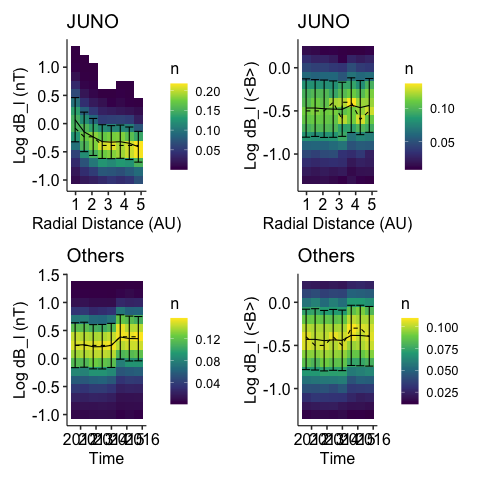

In [182]:
%%R
y <- "dB_l"
ylab <- "Log dB_l (nT)"
y_lim <- c(0.1,30)
p1 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("dB_l_dist")

y <- "dB_l_norm"
ylab <- "Log dB_l (<B>)"
y_lim <- c(0.05,2)
p2 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("dB_l_N1_dist")

p1 | p2

## Overview

In [ ]:
thresold = 0.2

def temp_plot(l1_df, y="j0_norm"):
    return l1_df.pipe(process_events_l2).hvplot(
        x="time", y=y, by="sat", hover_cols=["id_count"], width=300, height=300, legend=False
    )

direction_col = pl.col('k_x').abs()

((
    all_events_l1.pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="j0_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="j0_norm")
) + (
    all_events_l1.pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col > thresold).pipe(temp_plot, y="L_mn_norm")
    + all_events_l1.filter(direction_col < thresold).pipe(temp_plot, y="L_mn_norm")
)).cols(3)

:Layout
   .NdOverlay.I   :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.II  :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.III :NdOverlay   [sat]
      :Curve   [time]   (j0_norm,id_count)
   .NdOverlay.IV  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.V   :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)
   .NdOverlay.VI  :NdOverlay   [sat]
      :Curve   [time]   (L_mn_norm,id_count)

## Thickness

Note since want different y-axis titles (labels) for each facet, not different facet titles, it is not clear how to do this with `facet_wrap` after `pivot_longer`. Also these are different units, so it is better to plot them separately and combine them together.

### Evolution

In [28]:
%%R

x_var <- "time"
y_vars <- c("L_mn", "L_mn_norm")
xlab <- "Time"
ylabs <- c("Thickness (km)", "Normalized thickness (d_i)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r")

y_vars <- c("L_mn_n2", "L_mn_norm_n2")
ylabs <- c("Relative thickness", "Normalized relative thickness")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results

![](../figures/thickness_time.png){width=30%}
![](../figures/thickness_r.png){width=30%}
![](../figures/thickness_r_N2.png){width=30%}

### Different thickness standard

In [30]:
%%R
x_var <- "ref_radial_distance"
y_vars <- c("L_mn", "L_n", "L_k")
ylabs <- c("MN thickness", "N thickness", "k thickness")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness/thickness_r_diff")

y_vars <- c("L_mn_norm", "L_n_norm", "L_k_norm")
ylabs <- c("MN thickness", "N thickness", "k thickness")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("thickness/thickness_norm_r_diff")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 24 warnings (use warnings() to see them)


Results

![](../figures/thickness/thickness_r_diff.png){width=30%}
![](../figures/thickness/thickness_norm_r_diff.png){width=30%}


### Map

In [33]:
%%R
x_col <- "radial_distance"
y_col <- "L_mn"
y_lim <- NULL
xlab <- "Radial Distance (AU)"
ylab <- "Log Thickness (km)"
p <- plot_binned_data(JNO_events_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("thickness/thickness_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Distribution

In [146]:
%%R
y <- "L_mn"
ylab <- "Log Thickness (km)"
y_lim <- c(500,10000)
p1 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("thickness/thickness_mn_dist")

y <- "L_k"
p2 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("thickness/thickness_k_dist")


y <- "L_mn_norm"
ylab <- expression(Log~Thickness~(d[i]))
y_lim <- c(1,100)
p3 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("thickness/thickness_mn_N1_dist")

y <- "L_k_norm"
ylab <- expression(Log~Thickness~(d[i]))
y_lim <- c(1,100)
p4 <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("thickness/thickness_k_N1_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Histogram

In [22]:
%%R
x <- "L_mn_norm"
x_lim <- c(0,60)
bins <- 16
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_r_hist")

x <- "L_mn_norm_log"
x_lim <- c(0, 2)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim , bins = bins, facet_var=facet_var)
save_plot("thickness_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/thickness_N1_r_hist.png){width=500}
![](../figures/thickness_N1_log_r_hist.png){width=500}


## Current intensity

### Mean value

In [23]:
%%R
x_var <- "time"
y_vars <- c("j0", "j0_norm")
xlab <- "Time"
ylabs <- c("J (nA/m^2)",  "Normalized J (J_A)")
p <- plot_util(all_events_l2, x_var = x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_time")

x_var <- "ref_radial_distance"
xlab <- "Referred Radial Distance (AU)"
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r")

y_vars <- c("j0_n2", "j0_norm_n2")
ylabs <- c("Relative J", "Relative normalized J")
p <- plot_util(all_events_l2, x_var=x_var, y_vars = y_vars, xlab=xlab, ylabs=ylabs)
save_plot("current_r_N2")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


In addition: There were 20 warnings (use warnings() to see them)


Results

![](../figures/current_time.png){width=500}
![](../figures/current_r.png){width=500}
![](../figures/current_r_N2.png){width=500}

### Map

In [129]:

%%R
x_col <- "radial_distance"
y_col <- "j0"
y_lim <- c(0, 15)
xlab <- "Radial Distance (AU)"
ylab <- expression(Log~J~(nA~m^-2))
p <- plot_binned_data(JNO_events_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_r_dist")

y_col <- "j0_norm"
y_lim <- c(0.01, 1)
ylab <- expression(Log~Normalized~J~(J[A]))
p <- plot_binned_data(JNO_events_l1, x_col = x_col, y_col = y_col, x_bins = 8, y_bins = 32, y_lim = y_lim, log_y = TRUE)
p <- p + labs(x = xlab, y= ylab)
save_plot("current_N1_r_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Distribution

In [138]:
%%R
y <- "j0"
ylab <- expression(Log~J~(nA~m^-2))
y_lim <- c(0.01, 15)
p <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("current/current_mn_dist")

y <- "j0_k"
p <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("current/current_k_dist")


y <- "j0_norm"
ylab <- expression(Log~J~(J[A]))
y_lim <- c(0.01, 1)
p <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("current/current_mn_N1_dist")

y <- "j0_k_norm"
p <- plot_dist(y=y, ylab=ylab, y_lim = y_lim)
save_plot("current/current_k_N1_dist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


### Histogram

In [25]:
%%R
x <- "j0_norm"
x_lim <- c(0, 1)
facet_var <- "r_bin"
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_r_hist")

x <- "j0_norm_log"
x_lim <- c(-2, 0)
p <- plot_limited_histogram(all_events_l1, x = x, x_lim = x_lim, bins = 8, facet_var=facet_var)
save_plot("current_N1_log_r_hist")

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image


Results

![](../figures/current_N1_r_hist.png){width=500}
![](../figures/current_N1_log_r_hist.png){width=500}
